### Imports

In [2]:
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.preprocessing import image
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import seaborn as sn
import pandas as pd 
import numpy as np
import scipy
import cv2

### Exploratory Data Analysis & Dropping Dupicates with different emotion

Reading data

In [3]:
data_path ="D://Everything/Development Setup/fer2013.csv"
data = pd.read_csv(data_path)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

Checking datatypes of the dataframe variables

In [5]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

These datatypes will be changed accordingly. The pixels variable should be an array of pixel values, the emotion variable should be categorical for the model to accept it.

In [6]:
# Checking null values in dataframe
data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no nulls in the dataframe.



In [9]:
def print_duplicates(data):

    # Find duplicate rows based on all columns
    duplicates = data[data.duplicated(keep=False)]

    # Group the duplicates by their values
    grouped_duplicates = duplicates.groupby(list(duplicates.columns))
    total_duplicates = len(grouped_duplicates)
    print("Total number of Duplicates: ", total_duplicates)

    # Iterate over each group of duplicates
    for _, group in grouped_duplicates:
        print(group)
        print('---')
        
print_duplicates(data)

Total number of Duplicates:  1051
       emotion                                             pixels     Usage
6458         0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
11286        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
13148        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
13402        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
15894        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
22198        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
28601        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  Training
---
      emotion                                             pixels     Usage
387         0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 ...  Training
2103        0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 ...  Training
---
       emotion                                             pixels     Usage
5459         0  0 0 0 0 0 0 0 1 5 4 11 17 29 44 5

This function print_duplicates is a simple function that returns duplicates within a dataframe grouped by columns.

The total number of duplicates found is 1051. But all of these instances looks like that they belong to the same emotion, therefore, it is just more trainig data for the model to learn from. On the other hand, if there was duplicates with non-matching emotions that wouold be a problem for the model while learning. Which will lead to bias and bad generalization.

Let's find out if ther exists any duplicates with non-matching emotion 


In [11]:

def duplicates_non_match_emotion(df):
    # Find duplicate rows based on the 'pixels' column
    duplicates = df[df.duplicated(subset=['pixels'], keep=False)]

    # Initialize a counter for total duplicates with non-matching emotions
    total_duplicates_with_diff_emotion = 0

    # Iterate over each duplicate row
    for index, row in duplicates.iterrows():
        # Get the pixel value and emotion for the current row
        current_pixels = row['pixels']
        current_emotion = row['emotion']

        # Find rows with the same pixel value but different emotion
        same_pixels_diff_emotion = df[(df['pixels'] == current_pixels) & (df['emotion'] != current_emotion)]

        if not same_pixels_diff_emotion.empty:
            print("Duplicate pixels with different emotions:")
            print("Current Row:")
            print(row)
            print("Rows with different emotions:")
            print(same_pixels_diff_emotion)
            print('---')

            # Increment the counter for duplicates with non-matching emotions
            total_duplicates_with_diff_emotion += len(same_pixels_diff_emotion)

    # Print the total number of duplicates with non-matching emotions
    print("Total duplicates with non-matching emotions:", total_duplicates_with_diff_emotion)

duplicates_non_match_emotion(data)


Duplicate pixels with different emotions:
Current Row:
emotion                                                    0
pixels     254 253 252 255 227 83 50 49 38 41 43 36 57 14...
Usage                                               Training
Name: 157, dtype: object
Rows with different emotions:
       emotion                                             pixels       Usage
28791        1  254 253 252 255 227 83 50 49 38 41 43 36 57 14...  PublicTest
---
Duplicate pixels with different emotions:
Current Row:
emotion                                                    0
pixels     18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...
Usage                                               Training
Name: 251, dtype: object
Rows with different emotions:
       emotion                                             pixels       Usage
32264        4  18 19 23 26 47 37 12 19 51 58 65 105 140 153 1...  PublicTest
---
Duplicate pixels with different emotions:
Current Row:
emotion                                

it appears that there are a total of 282 duplicates with non matching emotions. duplicates with same pixel values but different emotion classification. 

In [12]:

def remove_duplicates_with_diff_emotion(df):
    # Find duplicate rows based on the 'pixels' column
    duplicates = df[df.duplicated(subset=['pixels'], keep=False)]

    # Initialize a list to store the indices of rows to be removed
    indices_to_remove = []

    # Iterate over each duplicate row
    for index, row in duplicates.iterrows():
        # Get the pixel value and emotion for the current row
        current_pixels = row['pixels']
        current_emotion = row['emotion']

        # Find rows with the same pixel value but different emotion
        same_pixels_diff_emotion = df[(df['pixels'] == current_pixels) & (df['emotion'] != current_emotion)]

        if not same_pixels_diff_emotion.empty:
            # Add the indices of rows with different emotions to the list
            indices_to_remove.extend(same_pixels_diff_emotion.index)

    # Remove the rows with non-matching emotions
    df_cleaned = df.drop(indices_to_remove)

    # Reset the index of the cleaned dataframe
    df_cleaned = df_cleaned.reset_index(drop=True)

    return df_cleaned


In [13]:
len(data)

35887

In [15]:
data = remove_duplicates_with_diff_emotion(data)
len(data)

35727

In [16]:
duplicates_non_match_emotion(data)

Total duplicates with non-matching emotions: 0


In [28]:
duplicates = data[data.duplicated(subset='pixels')]
pixel_counts = duplicates.groupby('emotion').size()
print("duplicated emotions: ", pixel_counts.sum()), print(pixel_counts)

duplicated emotions:  1750
emotion
0    204
1     84
2    277
3    189
4    137
5    719
6    140
dtype: int64


(None, None)

let's visualize a comparison between duplicates of each emotion to the total number of instances within each of the same emotion.

for this visualization to happen we need to see the total instances of each emotion.

In [29]:
 emotions_count = data.groupby('emotion').size()
 print("total emotions: ", emotions_count.sum()), print(emotions_count)

total emotions:  35727
emotion
0    4921
1     542
2    5079
3    8983
4    6049
5    3967
6    6186
dtype: int64


(None, None)

Let's visualize it in a plot.

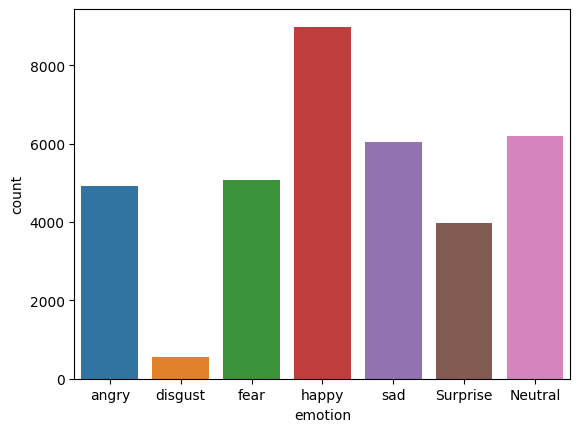

In [30]:
# Create the countplot
ax = sns.countplot(x='emotion', data=data)

# Set custom x-labels
emotion_label = ['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"]
ax.set_xticklabels(emotion_label)

# Display the plot
plt.show()


It's clearly shown from the visualization that the instances of each class are not balanced.

This can lead to a biased model perfromance, poor generalization to minority class, and finally misleading evaluation metrics.

Now let's create a plot that shows both total emotions and duplicate emotions side by side using bar plots

In [34]:
def Total_diff(data, duplicates, xtitle, lbl):

    duplic = duplicates.groupby('emotion').size()
    total = data.groupby('emotion').size()

    # Create the bar plot
    fig, ax = plt.subplots()

    # Define the width of each bar
    bar_width = 0.25

    # Define the x-axis positions
    x = np.arange(len(emotions))

    # Plot the bars for total emotions
    ax.bar(x, total, width=bar_width-0.5, label='Total Emotions')

    # Plot the bars for duplicated emotions next to the total emotions
    ax.bar(x + bar_width, duplic, width=bar_width-0.5, label=lbl)

    # Add labels and title
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')
    ax.set_title(xtitle)

    # Add x-axis tick labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(emotions.values())

    # Add text labels for total emotion counts
    for i, count in enumerate(total):
        ax.text(i, count + 50, str(count), ha='center', va='bottom')

    # Add text labels for duplicated emotion counts
    for i, count in enumerate(duplic):
        ax.text(i + bar_width, count + 50, str(count), ha='center', va='bottom')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


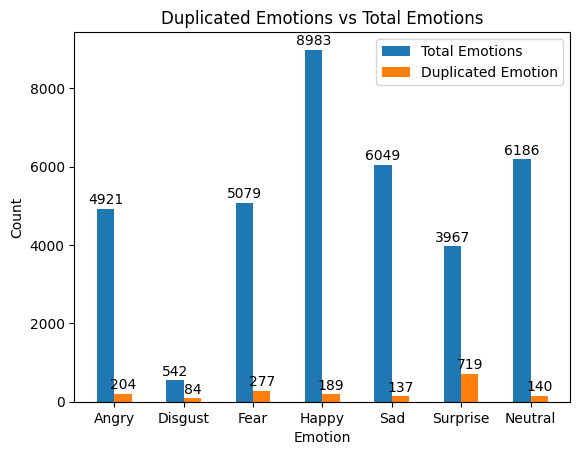

In [35]:
xtitle = "Duplicated Emotions vs Total Emotions"
label = "Duplicated Emotion"
Total_diff(data, duplicates, xtitle, label)

It is no preffered to drop all duplpicates from the dataset expecially becuase the dataset is imbalanced, therefore not all duplicates will be removed from the dataset.

But, let's check for outliers within the duplicated images.

### Data Pre-procesing - getting data ready to train the model

In [37]:
x_data = data["pixels"]
y_data = data["emotion"]
print("Features: \n " , x_data, '\n') , print("Traget:\n", y_data, "\n ")

Features: 
  0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35722    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35723    178 174 172 173 181 188 191 194 196 199 200 20...
35724    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35725    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35726    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35727, dtype: object 

Traget:
 0        0
1        0
2        2
3        4
4        6
        ..
35722    6
35723    3
35724    0
35725    3
35726    2
Name: emotion, Length: 35727, dtype: int64 
 


(None, None)

For this dataset, a problem of imbalanced class is presented. Therefore one way to solve this problem is by using data augmentation wich creates a variation of the input images by flipping, rotating, and rescaling.

Another method to solve imbalanced class problems is by using Over/Under sampling techniques in machine learning. Sampling methodologies creates synthesized or replicated instances to overcome bias when training the model.

In [38]:
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape, y_data.shape)

(62881, 1) (62881,)


In [39]:
y_data.value_counts()

0    8983
2    8983
4    8983
6    8983
3    8983
5    8983
1    8983
Name: emotion, dtype: int64

In [40]:
x_data = pd.Series(x_data.flatten())
x_data.info() , x_data.describe()

<class 'pandas.core.series.Series'>
RangeIndex: 62881 entries, 0 to 62880
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
62881 non-null  object
dtypes: object(1)
memory usage: 491.4+ KB


(None,
 count                                                 62881
 unique                                                33977
 top       80 81 77 69 66 59 70 89 112 132 140 142 144 14...
 freq                                                     90
 dtype: object)

In [41]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:2]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864]], dtype=float32)

In [42]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62881, 48, 48, 1)

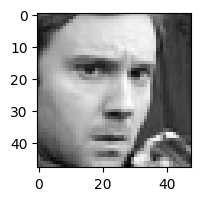

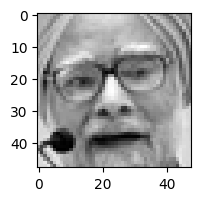

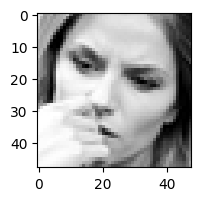

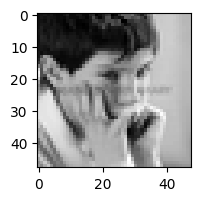

In [43]:
for ix in range(4):
    f = plt.figure(ix)
    f.set_figwidth(5)
    f.set_figheight(2)
    plt.imshow(x_data[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

In [44]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62881, 1)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state=45)

In [46]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56592, 7)

In [47]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6289, 7)

### Model Architecture

In [48]:
def Cnn_Lstm_model():

    model = Sequential([

    Input((48, 48, 1)),
    
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Reshape((-1,128)),
    (LSTM(128)),

    (Reshape((-1,64))),
    LSTM(64),

    Dense(200, activation='relu'),
    Dropout(0.6),

    Dense(7, activation = 'softmax')
    
    ])

    keras.utils.plot_model(model, to_file = "CNN_LSTM_model.png", show_shapes = True, show_dtype = True)

    model.summary()
    return model

In [49]:
model = Cnn_Lstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

### Defining Callbacks & model training

In [50]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    mid_delta=0.0001, 
    patience=1, 
    verbose=1
)

Earlystop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose =1,
)
TensBoard = TensorBoard(
    log_dir = 'logs-CNN-LSTM-Non-matching-duplicates'
)

checkpoint = ModelCheckpoint(
    filepath = 'CNN-LSTM-Non-matching-duplicates.h5',
    verbose = 1,
    save_best_only = True
)


### Compiling and fitting the model

In [51]:
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(x_train, y_train, epochs = epochs, validation_data=(x_test, y_test), callbacks = [lr_reduce, Earlystop, TensBoard, checkpoint])

Epoch 1/100
1769/1769 [==============================] - ETA: 0s - loss: 1.4705 - accuracy: 0.4292
Epoch 1: val_loss improved from inf to 1.14421, saving model to CNN-LSTM-Non-matching-duplicates.h5
1769/1769 [==============================] - 47s 16ms/step - loss: 1.4705 - accuracy: 0.4292 - val_loss: 1.1442 - val_accuracy: 0.5543 - lr: 2.0000e-04
Epoch 2/100
1766/1769 [============================>.] - ETA: 0s - loss: 1.0525 - accuracy: 0.5967
Epoch 2: val_loss improved from 1.14421 to 0.97035, saving model to CNN-LSTM-Non-matching-duplicates.h5
1769/1769 [==============================] - 29s 16ms/step - loss: 1.0524 - accuracy: 0.5967 - val_loss: 0.9704 - val_accuracy: 0.6295 - lr: 2.0000e-04
Epoch 3/100
1767/1769 [============================>.] - ETA: 0s - loss: 0.8981 - accuracy: 0.6611
Epoch 3: val_loss improved from 0.97035 to 0.93910, saving model to CNN-LSTM-Non-matching-duplicates.h5
1769/1769 [==============================] - 28s 16ms/step - loss: 0.8981 - accuracy: 0.661

### Evaluation of the model

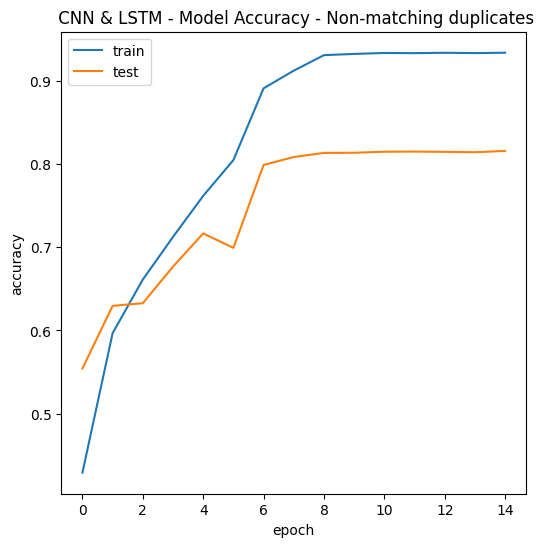

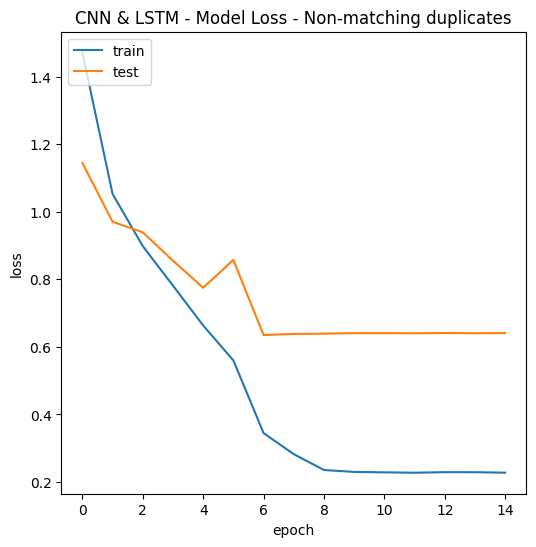

In [53]:
acc = plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(' CNN & LSTM - Model Accuracy - Non-matching duplicates')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
acc.savefig("ACC-CNN&LSTM-Dup")
plt.show()

loss = plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN & LSTM - Model Loss - Non-matching duplicates')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
loss.savefig("LOSS-CNN&LSTM-Dup")
plt.show()

In [54]:
%load_ext tensorboard 

In [55]:
# load model used to load model's architecture/ weights/ optimizer
#model = load_model('D:\Everything\GP-Code\h-Folder\CNN-LSTM-Non-matching-duplicates.h5')

In [56]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

197/197 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.8156
Accuracy of our model on validation data :  81.55509829521179 %


In [57]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 2s 4ms/step


[5, 3, 3, 2, 4, 0, 2, 1, 0, 0]

In [58]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[5, 3, 3, 2, 4, 0, 2, 1, 0, 0]

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       870
           1       1.00      1.00      1.00       924
           2       0.75      0.74      0.74       864
           3       0.85      0.81      0.83       929
           4       0.63      0.67      0.65       883
           5       0.94      0.95      0.94       874
           6       0.75      0.71      0.73       945

    accuracy                           0.82      6289
   macro avg       0.82      0.82      0.82      6289
weighted avg       0.82      0.82      0.82      6289



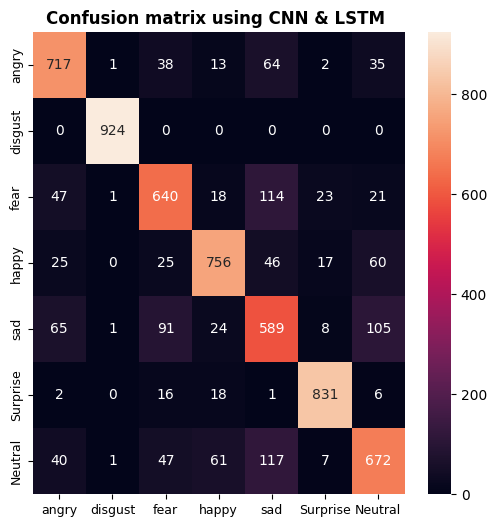

In [60]:
cm =  tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (6,6))
ax = plt.axes()
sn.heatmap(cm, annot = True, fmt = 'd')
ax.xaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"], fontsize=9);
ax.yaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"],  fontsize=9);

plt.title('Confusion matrix using CNN & LSTM ', fontsize = 12, fontweight=700)

plt.savefig("ConfMat-CNN&LSTM-Dup")

### Saliency Map


In [62]:
def display_samples_and_saliency_maps(model, x_data, y_data, num_samples_per_emotion=1):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
    samples_per_emotion = {label: 0 for label in emotion_labels}

    for i in range(len(x_data)):
        actual_emotion_index = np.argmax(y_data[i])
        actual_emotion_label = emotion_labels[actual_emotion_index]

        if samples_per_emotion[actual_emotion_label] >= num_samples_per_emotion:
            if all([count >= num_samples_per_emotion for count in samples_per_emotion.values()]):
                break
            else:
                continue

        samples_per_emotion[actual_emotion_label] += 1
        original_image = x_data[i]

        # Load image from array and normalize
        image = np.squeeze(original_image)
        image = cv2.resize(image, (48, 48))
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        image = np.expand_dims(image, axis=0)
        processed_image = image / 255.0

        # Compute saliency map
        img_tensor = tf.convert_to_tensor(processed_image, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            predictions = model(img_tensor)
            top_class_idx = tf.argmax(predictions[0])
            top_class_output = predictions[:, top_class_idx]
        grads = tape.gradient(top_class_output, img_tensor)
        saliency_map = np.max(np.abs(grads), axis=-1)[0]

        # Visualize saliency map with actual emotion
        if original_image.ndim == 3 and original_image.shape[-1] == 1:
            original_image = np.squeeze(original_image)

        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray' if original_image.ndim == 2 else None)
        plt.title(f"Original Image")
        plt.xlabel(f"Emotion: {actual_emotion_label}")

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='inferno')
        plt.title("Saliency Map")
        plt.show()


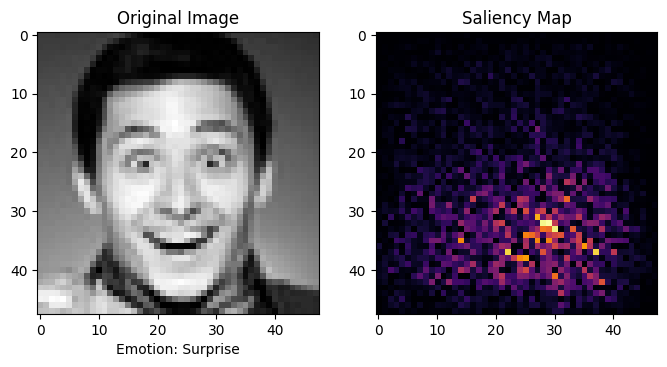

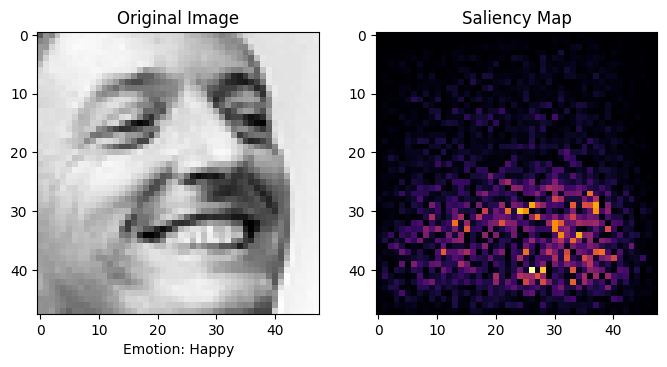

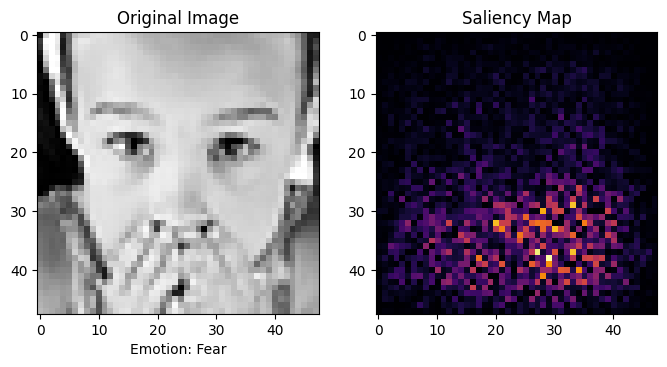

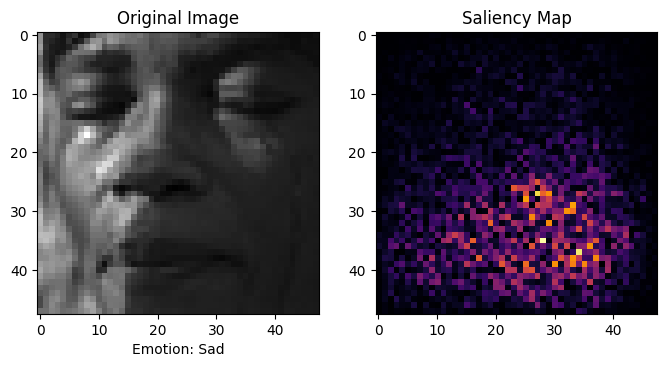

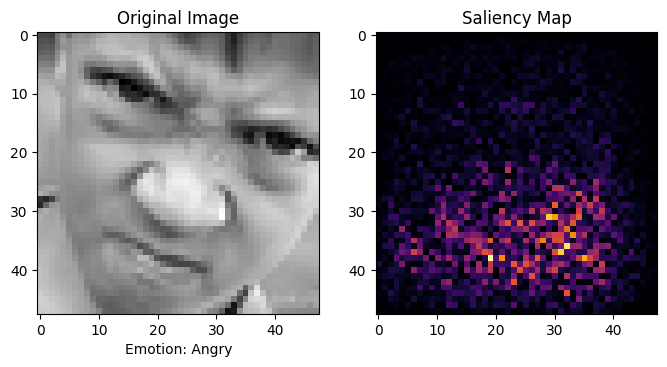

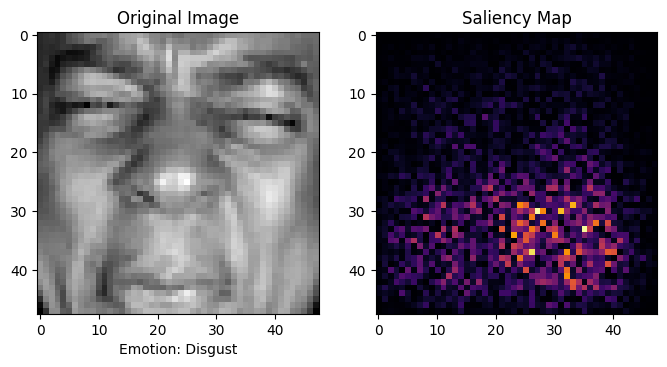

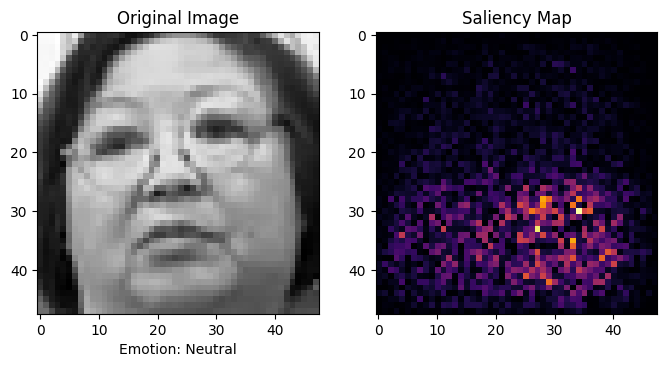

In [63]:
display_samples_and_saliency_maps(model, x_test, y_test)